## Setup and import libraries

In [ ]:
!pip install tensorflow-io

In [ ]:
!pip install --upgrade tensorflow-datasets

In [ ]:
# Import NumPy to handle array's and Matplotlib for plotting loss curves
import numpy as np
import matplotlib.pyplot as plt
import os

#Define random seed to avoid randomness to corrupt training
from numpy.random import seed
seed(1)
from tensorflow.random import set_seed
set_seed(1)

#Import tensorflow datasets
import tensorflow_datasets as tfds

# Import TensorFlow and relevant Keras classes to setup the model
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import models, layers, datasets, optimizers
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPool2D, Flatten, Dropout
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import TensorBoard, ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers.experimental import preprocessing
#import tensorflow_io as tfio

# Load the dataset, and create the train and validation datasets

In [ ]:
from google.colab import drive

drive.mount('/content/gdrive')
root_path = '/content/gdrive/My Drive/Patch_Camelyon_tfds/'

data, info = tfds.load("patch_camelyon", with_info=True, data_dir=root_path, shuffle_files=True)

train_ds = data['train']
valid_ds = data['validation']
test_ds = data['test']

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


# Visualize some of the images

In [ ]:
print(info)

tfds.core.DatasetInfo(
    name='patch_camelyon',
    version=2.0.0,
    description='The PatchCamelyon benchmark is a new and challenging image classification
dataset. It consists of 327.680 color images (96 x 96px) extracted from
histopathologic scans of lymph node sections. Each image is annoted with a
binary label indicating presence of metastatic tissue. PCam provides a new
benchmark for machine learning models: bigger than CIFAR10, smaller than
Imagenet, trainable on a single GPU.
',
    homepage='https://patchcamelyon.grand-challenge.org/',
    features=FeaturesDict({
        'id': Text(shape=(), dtype=tf.string),
        'image': Image(shape=(96, 96, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=327680,
    splits={
        'test': 32768,
        'train': 262144,
        'validation': 32768,
    },
    supervised_keys=('image', 'label'),
    citation="""@misc{b_s_veeling_j_linmans_j_winkens_t_cohen_2018

# Visualize data (our way, more efficient)

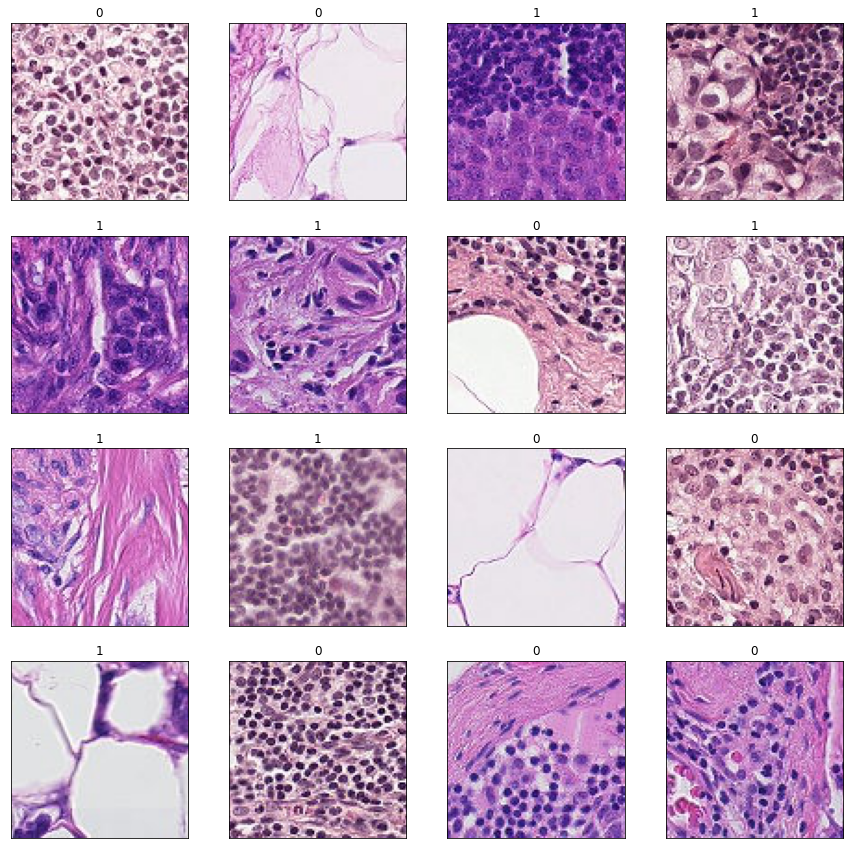

In [ ]:
i = 0
plt.figure(figsize=(15,15))
for data in train_ds.take(16):
  img = data["image"]
  label = data["label"]
  i += 1
  plt.subplot(4,4,i)
  plt.xticks([])
  plt.yticks([])
  plt.grid(False)
  plt.imshow(img, cmap=plt.cm.binary)
  plt.title(label.numpy())
plt.show()

# Data augmentation

In [ ]:
def split_data(data):
  return data["image"], data["label"]

BATCH_SIZE = 32
AUTOTUNE = tf.data.experimental.AUTOTUNE

train_ds = train_ds.map(split_data, num_parallel_calls=AUTOTUNE).shuffle(1024).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
valid_ds = valid_ds.map(split_data, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).cache().prefetch(buffer_size=AUTOTUNE)
test_ds = test_ds.map(split_data, num_parallel_calls=AUTOTUNE).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)

# Define smaller datasets, to make the first tests
# small_train_ds = train_ds.map(split_data, num_parallel_calls=AUTOTUNE).take(1024).cache().shuffle(1024).batch(BATCH_SIZE).prefetch(buffer_size=AUTOTUNE)
# small_valid_ds = valid_ds.map(split_data, num_parallel_calls=AUTOTUNE).take(1024).batch(BATCH_SIZE).cache().prefetch(buffer_size=AUTOTUNE)

In [ ]:
def random_brightness_layer(factor=0.4):
  return layers.Lambda(lambda x: tf.image.random_brightness(x, factor))

def random_hue_layer(factor=0.2):
  return layers.Lambda(lambda x: tf.image.random_hue(x, factor))

def random_saturation_layer(lower=0.8, upper=1.2):
  return layers.Lambda(lambda x: tf.image.random_saturation(x, lower, upper))

random_brightness_layer = random_brightness_layer()
random_hue_layer = random_hue_layer()
random_saturation_layer = random_saturation_layer()

data_augmentation = tf.keras.Sequential([
  layers.experimental.preprocessing.Rescaling(1./255),
  layers.experimental.preprocessing.RandomZoom((-0.125,0), fill_mode='reflect'),
  layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical",),
  layers.experimental.preprocessing.RandomRotation((-0.5,0.5)),
  layers.experimental.preprocessing.RandomContrast(0.4),
  random_brightness_layer,
  random_hue_layer,
  random_saturation_layer
], name="data_augmentation")

<dtype: 'float32'>
<dtype: 'float32'>


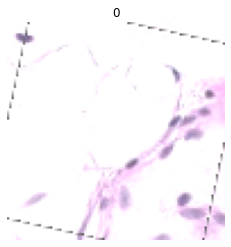

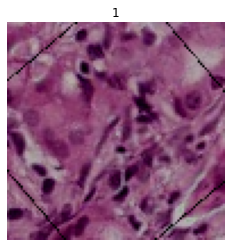

In [ ]:
def show(image, label):
  plt.figure()
  plt.imshow(image)
  plt.title(int(label.numpy()))
  plt.axis('off')

#Show augmented images
for image, label in train_ds.take(2):
  image = data_augmentation(image)
  show(image[0], label[0])
  print(image[0].dtype)

# Transfer Learning

In [ ]:
#Take the model
TLmodel = tf.keras.applications.VGG16(weights="imagenet", include_top = False, input_shape=(96,96,3))

#Print the summary and the number of layers
# TLmodel.summary()
# for i, layer in enumerate(TLmodel.layers):
#   print(i, layer.name)

#Now freeze the batch normalization layers
for layer in TLmodel.layers[:]:
  if "bn" in layer.name:
    layer.trainable = False

TLmodel.summary()

Model: "densenet169"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 96, 96, 3)]  0                                            
__________________________________________________________________________________________________
zero_padding2d_2 (ZeroPadding2D (None, 102, 102, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 48, 48, 64)   9408        zero_padding2d_2[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 48, 48, 64)   256         conv1/conv[0][0]                 
________________________________________________________________________________________

#Kernel visualization

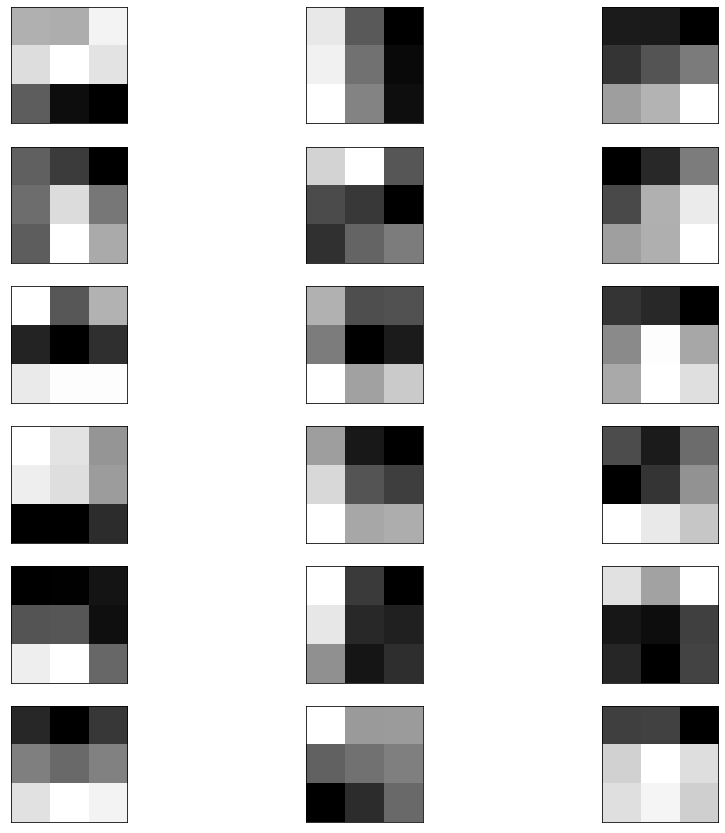

In [ ]:
#Extract the weights, meaning the filters and the biases used by the convolution layers
for layer in TLmodel.layers:
  if "conv" in layer.name:
    filters, biases = layer.get_weights()

#Normalize the filters, so we can better visualize them
f_min = filters.min()
f_max = filters.max()

filters = (filters - f_min) / (f_max - f_min)

# plot first few filters
n_filters, ix = 6, 1
plt.figure(figsize=(15,15))
for i in range(n_filters):
	# get the filter
	f = filters[:, :, :, i]
	# plot each channel separately
	for j in range(3):
		# specify subplot and turn of axis
		ax = plt.subplot(n_filters, 3, ix)
		ax.set_xticks([])
		ax.set_yticks([])
		# plot filter channel in grayscale
		plt.imshow(f[:, :, j], cmap='gray')
		ix += 1
# show the figure
plt.show()

In [ ]:
for i, layer in enumerate(model.layers):
  print(i,layer.name)

0 input_52
1 block1_conv1
2 block1_conv2
3 block1_pool
4 block2_conv1
5 block2_conv2
6 block2_pool
7 block3_conv1
8 block3_conv2
9 block3_conv3
10 block3_pool
11 block4_conv1
12 block4_conv2
13 block4_conv3
14 block4_pool
15 block5_conv1
16 block5_conv2
17 block5_conv3
18 block5_pool
19 flatten_10
20 dense_56


# Model Definition

In [ ]:
#Define a functional model
#Define the input
input = Input((96,96,3))

#First of all, data augmentation
x = data_augmentation(input)

#Insert the transfer learning model
x = TLmodel(x, training = False)

#
x = keras.layers.GlobalMaxPooling2D()(x)
x = keras.layers.Dropout(0.2)(x)
out = keras.layers.Dense(1, activation ='sigmoid')(x)

#Define the new model, use as input the TLmodel one, and as output the single neuron dense layer for our task
model = Model(inputs = input, outputs = out)

#Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4), loss = tf.keras.losses.BinaryCrossentropy(), metrics = ["accuracy"])

#print summary and the number of layers
model.summary()

Model: "functional_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 96, 96, 3)]       0         
_________________________________________________________________
data_augmentation (Sequentia (None, 96, 96, 3)         0         
_________________________________________________________________
densenet169 (Functional)     (None, 3, 3, 1664)        12642880  
_________________________________________________________________
global_max_pooling2d (Global (None, 1664)              0         
_________________________________________________________________
dropout (Dropout)            (None, 1664)              0         
_________________________________________________________________
dense (Dense)                (None, 1)                 1665      
Total params: 12,644,545
Trainable params: 12,327,745
Non-trainable params: 316,800
____________________________________

# Training

In [ ]:
#Define the folder where to save and load data and models
folder = os.path.join(root_path,'models_NN','Info',"DenseNetFinal1693")                                                                                                                                                                
savename = "Pcam_TL/DenseNetFinal3.h5"

In [ ]:
#Use the model checkpoint to save the model
callbacks = [ModelCheckpoint(os.path.join(root_path,'models_NN',savename), save_best_only=True)]

#Train
history = model.fit(train_ds, validation_data = valid_ds, epochs = 30, callbacks = callbacks, verbose = 1)

In [ ]:
#Load the best model
model = models.load_model(os.path.join(root_path,'models_NN',savename))

In [ ]:
#Evaluate the model on the test
test_loss, test_accuracy = model.evaluate(test_ds)

In [ ]:
#Evaluate and plot the graphs of accuracy and loss.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

#Evaluate and plot the graphs of accuracy and loss.
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

plt.figure()
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')
plt.xlabel('epoch')
plt.grid()
plt.savefig(os.path.join(folder,"accuracy.png"))

plt.figure()
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,1.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.savefig(os.path.join(folder,"loss.png"))
plt.grid()
plt.show()

f = open(os.path.join(folder,"info.txt"), "w")
best_epoch = np.argmin(val_loss)
f.writelines("Best epoch: " + str(best_epoch + 1) + "\n")
f.write("Training accuracy: " + str(acc[best_epoch]) + "\n")
f.write("Validation accuracy: " + str(val_acc[best_epoch]) + "\n")
f.write("Training loss: " + str(loss[best_epoch]) + "\n")
f.write("Validation loss: " + str(val_loss[best_epoch]) + "\n\n")
f.write("Test accuracy: " + str(test_accuracy) + "\n")
f.write("Test loss: " + str(test_loss) + "\n")
f.close()

# Hyperparameters tuning

In [ ]:
#Define the input of the functional model
def model_builder(hp):
  hp_l2_regularizer = hp.Choice('l2_regularizer', values = [1e-2, 1e-3, 1e-4]) 
  hp_units = hp.Choice('units', values = [32, 64, 128, 256, 512])
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 5e-3, 1e-3, 5e-4, 1e-4]) 

  input = Input((96,96,3))
  #x = data_augmentation(input)
  x = TLmodel.output

  x = tf.keras.layers.Flatten()(x)
  x = tf.keras.layers.Dense(256, activation ='relu')(x)
  x = tf.keras.layers.Batch_Normalization()(x)
  out = tf.keras.layers.Dense(1, activation ='sigmoid')(x)

  #Define the new model, use as input the TLmodel one, and as output the single neuron dense layer for our task
  model = Model(inputs = TLmodel.input, outputs = out)

  #Define the new model, use as input the TLmodel one, and as output the single neuron dense layer for our task
  # model = Model(inputs = TLmodel.input, outputs = out)

  #Compile the model
  model.compile(optimizer=tf.keras.optimizers.Adam(), loss = tf.keras.losses.BinaryCrossentropy(), metrics = ["accuracy"])

  return model

In [ ]:
tuner = kt.Hyperband(model_builder,
                     objective = 'val_loss', 
                     max_epochs = 10)   

class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

tuner.search(train_ds, epochs = 10, validation_data = valid_ds, callbacks = [ClearTrainingOutput()])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
Units: {best_hps.get('units')} \n
Optimal learning rate for the optimizer: {best_hps.get('learning_rate')} \n
L2 regularization factor: {best_hps.get('l2_regularizer')}
""")